In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyextremes import EVA

print("Todos los paquetes importados correctamente")


Todos los paquetes importados correctamente


In [76]:
station = 1190
# We create some random continuous time series with some extremes
flowdata = pd.read_csv(f"../../../Status_Outlook_Bulletin/stations/data/{station}.csv",parse_dates=['Fecha'],index_col="Fecha",dayfirst=True,na_values="NA")
# Convertir el índice a datetime por si acaso
flowdata.index = pd.to_datetime(flowdata.index, dayfirst=True)
diff = pd.date_range(start = flowdata.index[0].strftime('%Y-%m-%d'), end = flowdata.index[-1].strftime('%Y-%m-%d'),freq='D')
# Re-index the dataframe based on the missind date variable
flowdata = flowdata.reindex(diff,fill_value=None)
# Set index Fecha
flowdata.index.name = 'Fecha'
flowdata = flowdata.rename_axis("date")
# Change columns names
flowdata.columns = ['flow']

#month and year column
flowdata['month'] = flowdata.index.month
flowdata['year'] = flowdata.index.year
flowdata = flowdata.reset_index()

#check whether or not there is enough data? 
print(station)
print(f"There are {flowdata['year'].max() - flowdata['year'].min()} years of data in this file.")
print(f"There are {sum(flowdata['flow'].isnull())} missing data points, which is {np.round(sum(flowdata['flow'].isnull())/len(flowdata) * 100,2)}% of the total data")

1190
There are 55 years of data in this file.
There are 542 missing data points, which is 2.7% of the total data


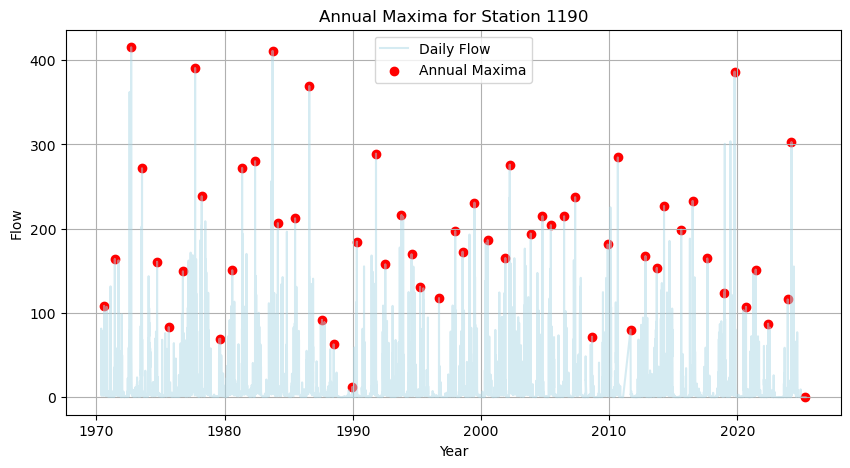

In [84]:
# Prepare the time series: set 'date' as index and use the 'flow' column
flowdata_ts = flowdata.set_index('date')['flow'].dropna()

# Agrupar los datos por año y encontrar la fecha del máximo
max_dates = flowdata_ts.groupby(flowdata_ts.index.year).idxmax()

# Usar las fechas encontradas para obtener los valores máximos
annual_maxima = flowdata_ts.loc[max_dates]

# Graficar annual maxima
plt.figure(figsize=(10, 5))
plt.plot(flowdata_ts.index, flowdata_ts.values, label='Daily Flow', color='lightblue', alpha=0.5)
plt.scatter(annual_maxima.index, annual_maxima.values, color='red', label='Annual Maxima')
plt.title(f'Annual Maxima for Station {station}')
plt.xlabel('Year')
plt.ylabel('Flow')
plt.legend()
plt.grid()
plt.show()

In [79]:
model = EVA(flowdata_ts)

In [80]:
model.set_extremes(extremes=annual_maxima) 

In [81]:
model.fit_model()
summary = model.get_summary(
    return_period=[2, 5, 10, 20, 25, 50, 100, 250, 500, 1000,5000],
    alpha=0.95,
    n_samples=1000,
)
print(summary)

               return value    lower ci      upper ci
return period                                        
2.0              187.004654   15.279262  3.028650e+02
5.0              269.104854  230.596399  5.203554e+03
10.0             316.655359  275.483351  2.698013e+05
20.0             357.626882  308.842816  1.153210e+07
25.0             369.744190  318.372416  3.984929e+07
50.0             404.608961  344.206927  1.476015e+09
100.0            435.814686  365.808342  4.808350e+10
250.0            472.284361  386.414233  5.549805e+12
500.0            496.716485  390.685000  2.264230e+14
1000.0           518.748955  397.930318  9.648604e+15
5000.0           561.953680  411.052641  6.192232e+19


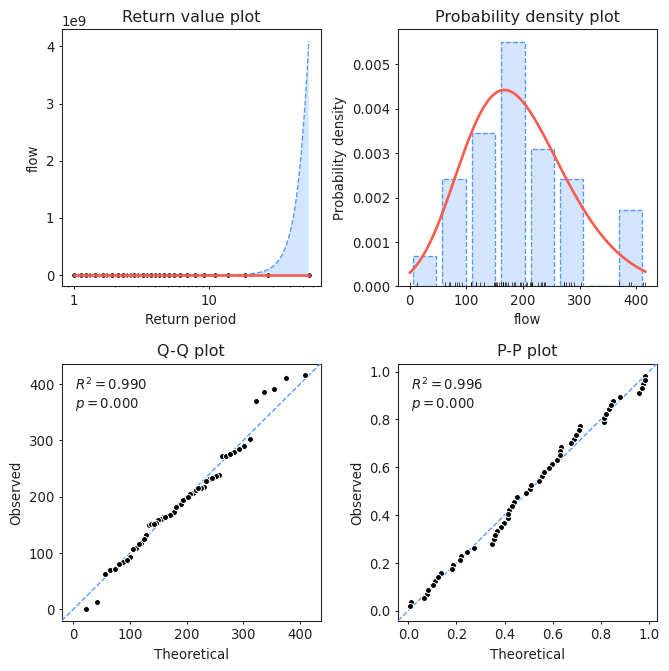

In [82]:
model.plot_diagnostic(alpha=0.95);
plt.show()

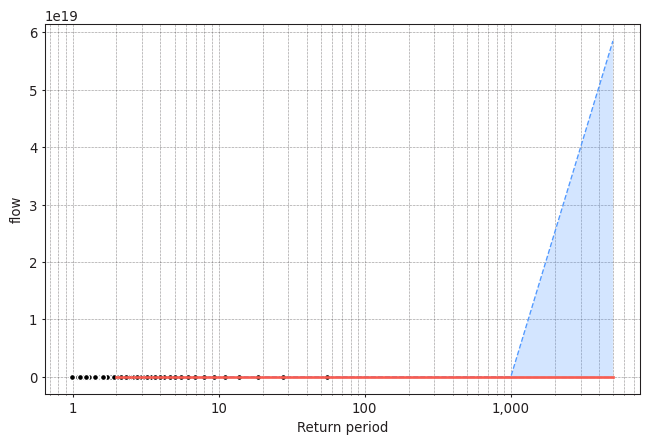

In [83]:
model.plot_return_values(alpha=0.95, return_period=[2, 5, 10, 20, 25, 50, 100, 250, 500, 1000,5000]);
plt.show()